Labels preparation

In [12]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import StratifiedShuffleSplit

from multitask_training.BertForHierarchicalClassification import BertForHierarchicalClassification

cleaner = lambda col: col.str.strip().str.lower()

df = pd.read_csv('./data_cleaned_manual_combined.csv')
df[['Global Subject', 'Question Intent']] = df[['Global Subject', 'Question Intent']].apply(cleaner)
#load questions from file
dataset = pd.read_csv("./validation_data.csv")

dataset[['Global Subject', 'Question Intent']] = dataset[['Global Subject', 'Question Intent']].apply(cleaner)

labels_gs = pd.concat([df['Global Subject'], dataset['Global Subject']]).unique()
labels_qi = pd.concat([df['Question Intent'], dataset['Question Intent']]).unique()

id2label_gs = {i: label for i, label in enumerate(labels_gs)}
label2id_gs = {label: i for i, label in enumerate(labels_gs)}

id2label_qi = {i: label for i, label in enumerate(labels_qi)}
label2id_qi = {label: i for i, label in enumerate(labels_qi)}

Now we'll preprocess all the data by encoding it

In [13]:
from transformers import AutoTokenizer, PreTrainedModel
import numpy as np

# https://huggingface.co/docs/transformers/v4.46.2/en/model_doc/auto#transformers.AutoTokenizer.from_pretrained
# https://huggingface.co/docs/transformers/v4.46.2/en/model_doc/bert#transformers.BertTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


def preprocess_data(example):
    question = example['Question']

    # https://huggingface.co/docs/transformers/v4.46.2/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.__call__
    encodings = tokenizer(question, padding="max_length", truncation=True, max_length=128)
    label_gs = label2id_gs[example['Global Subject']]
    label_qi = label2id_qi[example['Question Intent']]

    encodings.update({'labels_main': label_gs, 'labels_sub': label_qi})

    return encodings

In [14]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, val_index = next(split.split(df, df['Question Intent']))

strat_train_set = df.iloc[train_index].reset_index(drop=True)
strat_val_set = df.iloc[val_index].reset_index(drop=True)

train_dataset = Dataset.from_pandas(strat_train_set)
eval_dataset = Dataset.from_pandas(strat_val_set)

train_dataset = train_dataset.map(preprocess_data, remove_columns=train_dataset.column_names)
eval_dataset = eval_dataset.map(preprocess_data, remove_columns=eval_dataset.column_names)

train_dataset.set_format("torch")
eval_dataset.set_format("torch")

Map:   0%|          | 0/931 [00:00<?, ? examples/s]

Map:   0%|          | 0/233 [00:00<?, ? examples/s]

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(eval_pred):
    # Unpack predictions and labels
    predictions, labels = eval_pred

    # If predictions and labels are tuples, unpack them
    if isinstance(predictions, tuple):
        logits_main, logits_sub = predictions
    else:
        # If not a tuple, handle accordingly (unlikely in this case)
        logits_main, logits_sub = predictions

    if isinstance(labels, tuple):
        labels_main, labels_sub = labels
    else:
        # If labels are not a tuple, they might be a dict or array
        labels_main = labels['labels_main']
        labels_sub = labels['labels_sub']

    # Convert logits to predicted class indices
    preds_main = np.argmax(logits_main, axis=1)
    preds_sub = np.argmax(logits_sub, axis=1)

    # Compute metrics for main topic
    acc_main = accuracy_score(labels_main, preds_main)
    precision_main, recall_main, f1_main, _ = precision_recall_fscore_support(
        labels_main, preds_main, average='weighted', zero_division=0
    )

    # Compute metrics for subtopic
    acc_sub = accuracy_score(labels_sub, preds_sub)
    precision_sub, recall_sub, f1_sub, _ = precision_recall_fscore_support(
        labels_sub, preds_sub, average='weighted', zero_division=0
    )

    # Combine metrics into a dictionary
    metrics = {
        'accuracy_main': acc_main,
        'precision_main': precision_main,
        'recall_main': recall_main,
        'f1_main': f1_main,
        'accuracy_sub': acc_sub,
        'precision_sub': precision_sub,
        'recall_sub': recall_sub,
        'f1_sub': f1_sub,
    }

    return metrics


In [16]:
import torch

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
print(f"Current CUDA device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")


CUDA available: True
Number of GPUs: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3070 Ti


In [17]:
import wandb

wandb.init(project='tesi')

eval/accuracy_main,▁▂▃▆▇▇▇▇▇▇▇▇█████████
eval/accuracy_sub,▁▂▃▅▅▆▆▆▆▇▇▇▇▇███████
eval/f1_main,▁▃▃▆▇▇██▇████████████
eval/f1_sub,▁▂▃▄▅▅▅▆▆▇▇▇▇▇███████
eval/loss,█▇▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
eval/precision_main,▁▄▅▇▇▇███████████████
eval/precision_sub,▁▂▃▄▅▅▆▆▆▆▇▇▇▇███████
eval/recall_main,▁▂▃▆▇▇▇▇▇▇▇▇█████████
eval/recall_sub,▁▂▃▅▅▆▆▆▆▇▇▇▇▇███████
eval/runtime,▃▃▃▃▁▁▄▁▂▃▁▂▂▁▂▂▂▂▂▂█
eval/samples_per_second,▆▆▅▆██▅█▇▆█▇▇█▇▇▇▇▇▇▁


In [18]:
from transformers import TrainingArguments, Trainer

model = BertForHierarchicalClassification.from_pretrained(
    # 'bert-base-uncased',
    'distilbert-base-uncased',
    num_main_topics=len(labels_gs),
    num_subtopics=len(labels_qi)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    learning_rate=2e-5,
    warmup_ratio=0.1,  # Warmup for the first 10% of steps
    lr_scheduler_type='linear',  # Linear scheduler
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_strategy='epoch',
    logging_strategy='epoch',
    eval_strategy='epoch',
    logging_dir='./logs',
    load_best_model_at_end=True,  # Load the best model at the end based on evaluation metric
    metric_for_best_model='f1_sub',  # Use subtopic F1-score to determine the best model
    greater_is_better=True,  # Higher metric indicates a better model,
    report_to='wandb'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

print(f"Trainer is using device: {trainer.args.device}")

trainer.train()

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForHierarchicalClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier_main.bias', 'classifier_main.weight', 'classifier_sub.bias', 'classifier_sub.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.va

Trainer is using device: cuda:0


Epoch,Training Loss,Validation Loss,Accuracy Main,Precision Main,Recall Main,F1 Main,Accuracy Sub,Precision Sub,Recall Sub,F1 Sub
1,5.410100,5.267126,0.248927,0.281040,0.248927,0.163628,0.090129,0.008123,0.090129,0.014903
2,5.057200,4.738736,0.394850,0.421561,0.394850,0.344517,0.218884,0.144788,0.218884,0.125851
3,4.345000,3.902919,0.570815,0.686147,0.570815,0.490675,0.261803,0.258038,0.261803,0.210755
4,3.602900,3.203882,0.738197,0.815995,0.738197,0.729472,0.369099,0.316349,0.369099,0.262113
5,3.040800,2.701375,0.845494,0.851838,0.845494,0.844161,0.442060,0.363825,0.442060,0.342116
6,2.643500,2.399287,0.871245,0.878582,0.871245,0.872967,0.506438,0.395926,0.506438,0.400724
7,2.357500,2.223547,0.871245,0.881490,0.871245,0.873797,0.532189,0.456238,0.532189,0.440177
8,2.110100,2.089046,0.888412,0.906977,0.888412,0.890896,0.583691,0.525203,0.583691,0.509384
9,1.912600,1.975733,0.875536,0.892331,0.875536,0.878667,0.587983,0.541144,0.587983,0.520718
10,1.740700,1.933229,0.879828,0.888924,0.879828,0.881345,0.587983,0.539355,0.587983,0.513903


TrainOutput(global_step=1180, training_loss=2.194952919523595, metrics={'train_runtime': 202.0038, 'train_samples_per_second': 92.176, 'train_steps_per_second': 5.841, 'total_flos': 1225298813383680.0, 'train_loss': 2.194952919523595, 'epoch': 20.0})

In [19]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 1.4125570058822632, 'eval_accuracy_main': 0.8841201716738197, 'eval_precision_main': 0.8933742373866109, 'eval_recall_main': 0.8841201716738197, 'eval_f1_main': 0.8857431753286971, 'eval_accuracy_sub': 0.7296137339055794, 'eval_precision_sub': 0.6997429744543848, 'eval_recall_sub': 0.7296137339055794, 'eval_f1_sub': 0.6982982049080456, 'eval_runtime': 0.6007, 'eval_samples_per_second': 387.886, 'eval_steps_per_second': 24.971, 'epoch': 20.0}


In [20]:
trainer.save_model(f'./models/{wandb.run.name}')

In [ ]:
import pandas as pd

test_dataset = Dataset.from_pandas(dataset)
test_dataset = test_dataset.map(preprocess_data, remove_columns=test_dataset.column_names)

predictions = trainer.predict(test_dataset)

In [35]:
# Unpack the logits
logits_main, logits_sub = predictions.predictions  # Assuming these are tuples

# Convert logits to predicted class indices
preds_main = np.argmax(logits_main, axis=1)  # Main topic predictions
preds_sub = np.argmax(logits_sub, axis=1)  # Subtopic predictions

# Map predicted indices to class labels
predicted_classes_main = [id2label_gs[pred] for pred in preds_main]
predicted_classes_sub = [id2label_qi[pred] for pred in preds_sub]

# Combine predictions in a DataFrame for analysis or saving
df_predictions = pd.DataFrame({
    'Main Prediction': predicted_classes_main,
    'Sub Prediction': predicted_classes_sub
})

df_predictions

,Main Prediction,Sub Prediction
0,start,greet
1,start,greet
2,start,greet
3,start,greet
4,start,greet
...,...,...
463,off_topic,off_topic
464,off_topic,off_topic
465,off_topic,off_topic
466,off_topic,off_topic


In [37]:
from sklearn.metrics import classification_report

merged_df = pd.merge(dataset, df_predictions, left_index=True, right_index=True)

print("BERT Main Class Combined Performance:")
print(classification_report(merged_df['Global Subject'], merged_df['Main Prediction'], zero_division=0))

print("BERT Sub Class Combined Performance:")
print(classification_report(merged_df['Question Intent'], merged_df['Sub Prediction'], zero_division=0))

BERT Main Class Combined Performance:
              precision    recall  f1-score   support

   automaton       0.78      0.80      0.79        75
     grammar       0.73      0.86      0.79        70
   off_topic       0.77      0.95      0.85       100
       start       1.00      0.17      0.30        40
       state       0.84      0.95      0.89        43
      theory       0.52      0.37      0.43        30
  transition       0.95      0.95      0.95       110

    accuracy                           0.81       468
   macro avg       0.80      0.72      0.71       468
weighted avg       0.82      0.81      0.78       468

BERT Sub Class Combined Performance:
                    precision    recall  f1-score   support

          accepted       0.59      1.00      0.74        10
             count       0.85      0.85      0.85        20
            cycles       1.00      0.60      0.75        10
        definition       0.00      0.00      0.00         4
       description       0.

In [38]:
correct_main = merged_df.loc[merged_df['Global Subject'] == merged_df['Main Prediction']]
conditional_accuracy = (correct_main['Question Intent'] == correct_main['Sub Prediction']).mean()

print(f"BERT Conditional Sub Class Accuracy: {conditional_accuracy:.2f}")

BERT Conditional Sub Class Accuracy: 0.75


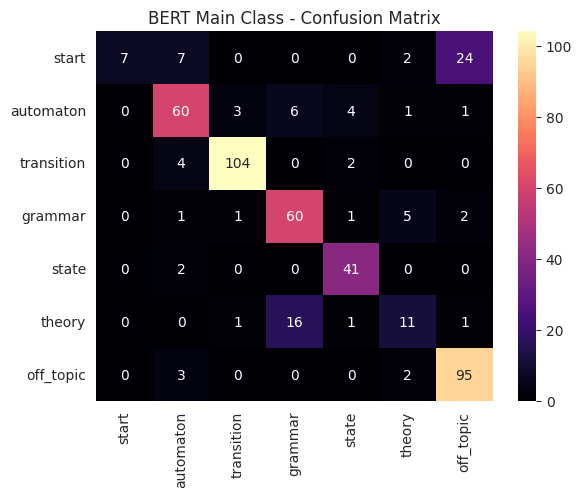

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette("magma", as_cmap=True)

# Main class confusion matrices

conf_matrix = confusion_matrix(merged_df['Global Subject'], merged_df['Main Prediction'], labels=labels_gs)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap=palette,
            xticklabels=labels_gs,
            yticklabels=labels_gs)
plt.title("BERT Main Class - Confusion Matrix")
plt.show()

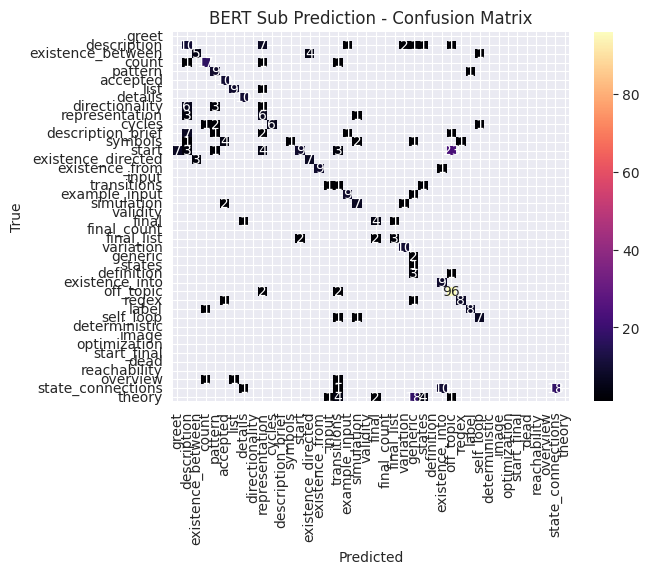

In [41]:
# BERT Subclass Confusion Matrix
conf_matrix_bert_sub = confusion_matrix(merged_df['Question Intent'], merged_df['Sub Prediction'],
                                        labels=labels_qi)

mask = conf_matrix_bert_sub == 0

sns.heatmap(conf_matrix_bert_sub,
            annot=True,
            fmt='d',
            cmap=palette,
            mask=mask,
            cbar=True,
            xticklabels=labels_qi,
            yticklabels=labels_qi)
plt.title("BERT Sub Prediction - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()